## Part 1: Measuring Distance Between Records

### The Foundation of Clustering

Clustering relies on **distance** (or **similarity**) measures:
- **Small distance** = Similar observations (should be in same cluster)
- **Large distance** = Different observations (should be in different clusters)

### Common Distance Metrics

| Metric | Formula | Use Case |
|--------|---------|----------|
| **Euclidean** | $\sqrt{\sum(x_i - y_i)^2}$ | Continuous variables, most common |
| **Manhattan** | $\sum|x_i - y_i|$ | Grid-like data, robust to outliers |
| **Cosine** | $1 - \frac{x \cdot y}{||x|| ||y||}$ | Text/sparse data, direction matters |

### 🔍 Business Context: Utilities Dataset

We'll analyze **22 utility companies** based on 8 characteristics:
- Financial metrics (Sales, Assets)
- Operational costs (Fixed_cost, Fuel_Cost)
- Performance (RoR = Rate of Return)
- Market characteristics (Cost, Load_factor, Demand_growth)

**Business Goal**: Group utilities into strategic categories for benchmarking and investment decisions.

---

In [1]:
library(tidyverse)

# Load data and use Company column as row names
utilities.df <- mlba::Utilities %>%
  column_to_rownames("Company")

# Preview the data
head(utilities.df)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


,Fixed_charge,RoR,Cost,Load_factor,Demand_growth,Sales,Nuclear,Fuel_Cost
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
Arizona,1.06,9.2,151,54.4,1.6,9077,0.0,0.628
Boston,0.89,10.3,202,57.9,2.2,5088,25.3,1.555
Central,1.43,15.4,113,53.0,3.4,9212,0.0,1.058
Commonwealth,1.02,11.2,168,56.0,0.3,6423,34.3,0.700
NY,1.49,8.8,192,51.2,1.0,3300,15.6,2.044
Florida,1.32,13.5,111,60.0,-2.2,11127,22.5,1.241


### 📋 Interpretation: Understanding the Data

**Key Variables**:
- `Sales`: Operating revenue (millions)
- `Fuel_Cost`: Cost of fuel per MWh
- `Fixed_cost`: Fixed operating costs
- `RoR`: Rate of Return (profitability)

**Why This Matters**: Companies with similar profiles face similar challenges and opportunities. Clustering helps identify peer groups for competitive analysis.

---

### Computing Euclidean Distance

In [2]:
# Compute Euclidean distance
# (to compute other distance measures, change the value in the method argument)
d <- dist(utilities.df, method = "euclidean")

# View distance matrix (first few rows/cols)
as.matrix(d)[1:6, 1:6]

,Arizona,Boston,Central,Commonwealth,NY,Florida
Arizona,0.0000,3989.408,140.4029,2654.278,5777.168,2050.529
Boston,3989.4081,0.000,4125.0441,1335.467,1788.068,6039.689
Central,140.4029,4125.044,0.0000,2789.760,5912.553,1915.155
Commonwealth,2654.2776,1335.467,2789.7597,0.000,3123.153,4704.363
NY,5777.1677,1788.068,5912.5529,3123.153,0.000,7827.429
Florida,2050.5294,6039.689,1915.1552,4704.363,7827.429,0.000


### 📋 Interpretation: Distance Matrix

**What You're Seeing**:
- Each cell shows distance between two companies
- Diagonal = 0 (company compared to itself)
- Matrix is symmetric (distance A→B = distance B→A)

**⚠️ CRITICAL PROBLEM**: 

Variables with **larger scales dominate** the distance calculation!

```
Sales: 3000-18000 (range = 15,000)
RoR:   6-15       (range = 9)
                   ↓
Sales differences swamp RoR differences!
```

**Solution**: **NORMALIZE** the data (just like k-NN!).

---

### 🎯 Critical Step: Normalizing Numerical Variables

### Why Normalization is Essential

| Without Normalization | With Normalization |
|----------------------|--------------------|
| ❌ Variables with large ranges dominate | ✅ All variables contribute equally |
| ❌ Units matter (dollars vs percentages) | ✅ Unit-free (standard deviations) |
| ❌ Misleading clusters | ✅ Meaningful clusters |

### What `scale()` Does

For each variable: $z = \frac{x - \bar{x}}{s}$

- **Center**: Subtract mean ($\bar{x}$) → Mean becomes 0
- **Scale**: Divide by standard deviation ($s$) → SD becomes 1

Result: **Z-scores** (number of standard deviations from mean)

---

In [3]:
# Normalize input variables
utilities.df.norm <- scale(utilities.df)

# Check: means should be ~0, SDs should be 1
colMeans(utilities.df.norm)
apply(utilities.df.norm, 2, sd)

Fixed_charge           RoR          Cost   Load_factor Demand_growth 
 4.128642e-16 -1.892426e-18 -1.334949e-16  7.652496e-17  7.222758e-17 
        Sales       Nuclear     Fuel_Cost 
 1.400395e-16  3.532528e-17 -9.793303e-17

Fixed_charge           RoR          Cost   Load_factor Demand_growth 
            1             1             1             1             1 
        Sales       Nuclear     Fuel_Cost 
            1             1             1

### 📋 Interpretation: Normalization Results

**What to Look For**:
- Means ≈ 0 (values like 1e-16 are essentially zero)
- Standard deviations = 1

**Business Impact**: Now a 1-unit difference in Sales has the **same weight** as a 1-unit difference in RoR when computing distances.

---

In [4]:
# Compute normalized distance based on Sales and Fuel Cost
d.norm <- dist(utilities.df.norm[,c("Sales","Fuel_Cost")], method="euclidean")

# Compare to unnormalized
d.unnorm <- dist(utilities.df[,c("Sales","Fuel_Cost")], method="euclidean")

cat("Normalized distance (first 3 pairs):\n")
print(as.matrix(d.norm)[1:3, 1:3])

cat("\nUnnormalized distance (first 3 pairs):\n")
print(as.matrix(d.unnorm)[1:3, 1:3])

Normalized distance (first 3 pairs):
          Arizona   Boston   Central 
Arizona  0.0000000 2.010329 0.7741795
Boston   2.0103293 0.000000 1.4657027
Central  0.7741795 1.465703 0.0000000

Unnormalized distance (first 3 pairs):
          Arizona  Boston   Central 
Arizona     0.0000    3989  135.0007
Boston   3989.0001       0 4124.0000
Central   135.0007    4124    0.0000


### 📋 Interpretation: Impact of Normalization

**Key Differences**:
- Unnormalized distances are **much larger** (dominated by Sales scale)
- Normalized distances give **equal weight** to both variables
- Rankings of "most similar" pairs may change!

**Best Practice**: **ALWAYS normalize** before clustering unless variables are already on comparable scales.

---

## Part 2: Hierarchical (Agglomerative) Clustering

### How Hierarchical Clustering Works

**Agglomerative** = Bottom-up approach

```
Step 1: Each observation = its own cluster (n clusters)
        A  B  C  D  E

Step 2: Merge two closest clusters
        AB  C  D  E  (n-1 clusters)

Step 3: Merge next two closest
        AB  CD  E    (n-2 clusters)

...

Step n: All in one cluster
        ABCDE        (1 cluster)
```

### Linkage Methods (How to Measure Distance Between Clusters)

| Method | Description | Best For |
|--------|-------------|----------|
| **Single** | Minimum distance between any two points | Long, chain-like clusters |
| **Complete** | Maximum distance between any two points | Compact, spherical clusters |
| **Average** | Average distance between all pairs | Balanced, most common |
| **Ward** | Minimizes within-cluster variance | Equal-sized clusters |

---

### Dendrograms: Visualizing the Clustering Process

agg_record_1119363482 
                    2

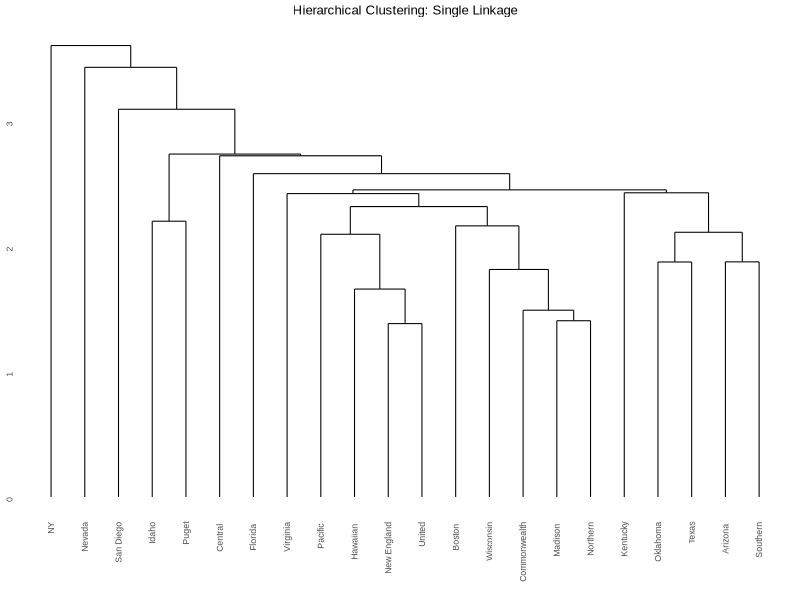

In [9]:
library(ggplot2)
library(ggdendro)
library(IRdisplay)

# Compute normalized distance for ALL variables
d.norm <- dist(utilities.df.norm, method="euclidean")

# In hclust() set argument method to:
# "ward.D", "single", "complete", "average", "median", or "centroid"

# Single linkage
hc1 <- hclust(d.norm, method="single")

# Save and display as PNG to avoid text bunching
png("dendrogram_single.png", width=800, height=600)
print(ggdendrogram(hc1) + 
  labs(title="Hierarchical Clustering: Single Linkage") +
  theme(plot.title = element_text(hjust = 0.5)))
dev.off()
display_png(file="dendrogram_single.png")

### 📋 Interpretation: Single Linkage Dendrogram

**How to Read a Dendrogram**:
- **X-axis**: Individual companies
- **Y-axis**: Height = distance at which clusters merge
- **Lower merge** = More similar observations
- **Cut horizontal line** = Choose number of clusters

**Single Linkage Characteristics**:
- Tends to create **chain-like** clusters
- One observation joins at a time
- Sensitive to outliers

**Business Issue**: May not create balanced, interpretable segments.

---

agg_record_750022946 
                   2

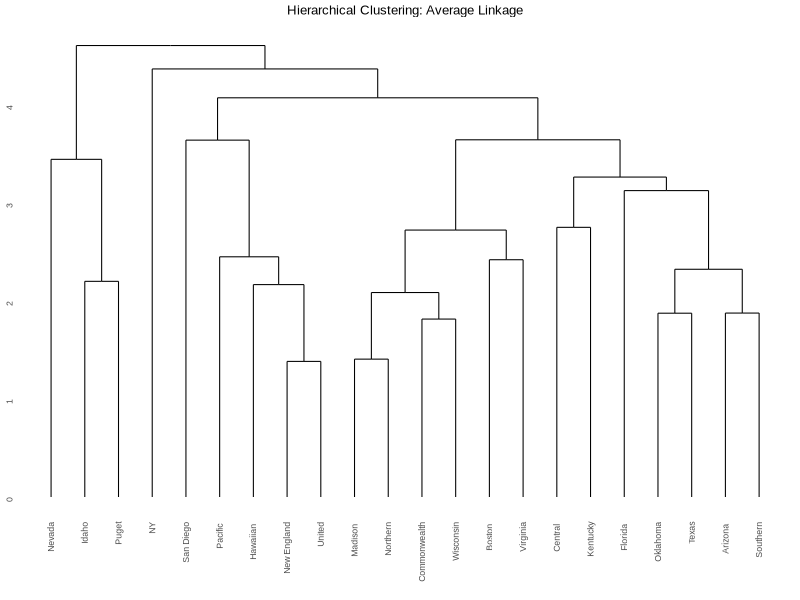

In [11]:
# Average linkage
hc2 <- hclust(d.norm, method="average")

# Save and display as PNG to avoid text bunching
png("dendrogram_average.png", width=800, height=600)
print(ggdendrogram(hc2) + 
  labs(title="Hierarchical Clustering: Average Linkage") +
  theme(plot.title = element_text(hjust = 0.5)))
dev.off()
display_png(file="dendrogram_average.png")

### 📋 Interpretation: Average Linkage Dendrogram

**Average Linkage Characteristics**:
- More **balanced clusters** than single linkage
- Considers all pairwise distances between clusters
- Less sensitive to outliers
- **Most commonly used** in practice

**Business Value**: Creates more interpretable segments that can be actionable for marketing or operations.

---

### Comparing Dendrograms with Cut Lines

agg_record_1630839345 
                    2

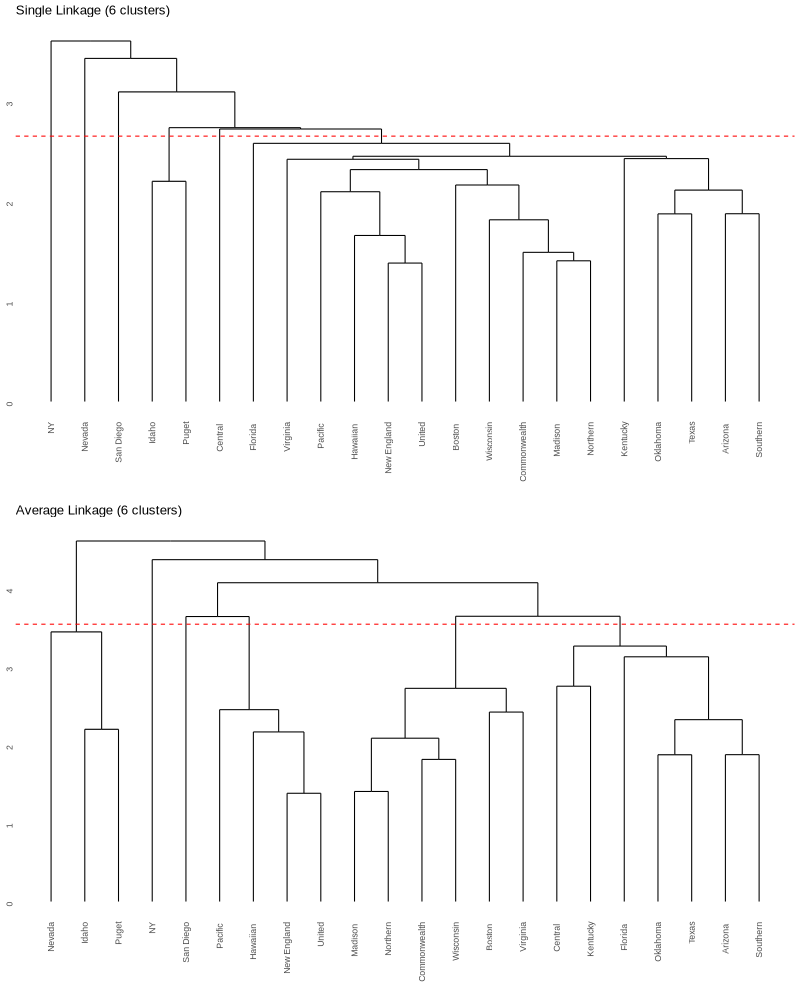

In [12]:
library(gridExtra)

# Helper function to add cut line for k clusters
addCutline <- function(g, hc, ncluster) {
  heights <- rev(hc$height)
  cut_at <- 0.5 * (heights[ncluster] + heights[ncluster - 1])
  return (g + geom_hline(yintercept=cut_at, color='red', linetype=2))
}

# Create dendrograms with cut lines for 6 clusters
g1 <- ggdendrogram(hc1) + labs(title="Single Linkage (6 clusters)")
g2 <- ggdendrogram(hc2) + labs(title="Average Linkage (6 clusters)")

# Save and display as PNG to avoid text bunching
png("dendrogram_comparison.png", width=800, height=1000)
grid.arrange(addCutline(g1, hc1, 6), addCutline(g2, hc2, 6), nrow=2)
dev.off()
display_png(file="dendrogram_comparison.png")

### 📋 Interpretation: Choosing the Cut Point

**Red Dashed Line** = Where we "cut" the dendrogram to get 6 clusters

**How to Choose Number of Clusters**:
1. **Business judgment**: How many segments can you operationalize?
2. **Dendrogram inspection**: Look for large jumps in height
3. **Interpretability**: Can you explain/name each cluster?
4. **Practical constraints**: Budget for # of marketing campaigns, etc.

**Visual Cue**: Cut before a **big jump** in height (large vertical gap) → Suggests natural groupings

---

### Extracting Cluster Assignments

In [13]:
# Get cluster membership from single linkage
memb1 <- cutree(hc1, k = 6)
cat("Single Linkage - Cluster assignments:\n")
print(memb1)

cat("\nCluster sizes:\n")
print(table(memb1))

Single Linkage - Cluster assignments:
    Arizona       Boston      Central  Commonwealth           NY     Florida  
           1            1            2            1            3            1 
   Hawaiian         Idaho     Kentucky     Madison        Nevada  New England 
           1            4            1            1            5            1 
    Northern     Oklahoma     Pacific         Puget    San Diego     Southern 
           1            1            1            4            6            1 
       Texas    Wisconsin       United     Virginia 
           1            1            1            1 

Cluster sizes:
memb1
 1  2  3  4  5  6 
16  1  1  2  1  1 


### 📋 Interpretation: Single Linkage Cluster Sizes

**Problem with Single Linkage**:
- Often creates **unbalanced clusters**
- One huge cluster + many tiny clusters
- Example: Cluster 1 might have 18 companies, others have 1-2 each

**Business Issue**: Hard to create tailored strategies for clusters of size 1!

---

In [14]:
# Get cluster membership from average linkage
memb <- cutree(hc2, k = 6)
cat("Average Linkage - Cluster assignments:\n")
print(memb)

cat("\nCluster sizes:\n")
print(table(memb))

Average Linkage - Cluster assignments:
    Arizona       Boston      Central  Commonwealth           NY     Florida  
           1            2            1            2            3            1 
   Hawaiian         Idaho     Kentucky     Madison        Nevada  New England 
           4            5            1            2            5            4 
    Northern     Oklahoma     Pacific         Puget    San Diego     Southern 
           2            1            4            5            6            1 
       Texas    Wisconsin       United     Virginia 
           1            2            4            2 

Cluster sizes:
memb
1 2 3 4 5 6 
7 6 1 4 3 1 


### 📋 Interpretation: Average Linkage Cluster Sizes

**Better Balance**:
- More **even distribution** across clusters
- Each cluster has enough members for analysis
- Easier to develop segment-specific strategies

**Next Step**: Validate that clusters are meaningfully different!

---

## Part 3: Validating Clusters

### Why Validation Matters

**Key Question**: Are the clusters **meaningfully different** on important variables?

**Validation Methods**:
1. **Heatmaps**: Visual inspection of patterns
2. **Cluster profiles**: Compare means across clusters
3. **Statistical tests**: ANOVA/MANOVA to test differences

### Using Heatmaps for Visual Validation

**Heatmap** = Color-coded matrix showing variable values for each observation
- **Rows** = Observations (sorted by cluster)
- **Columns** = Variables
- **Color intensity** = Value magnitude

**What to Look For**:
- Distinct **color patterns** within clusters
- Different patterns **between** clusters
- Evidence that clustering captured meaningful structure

---

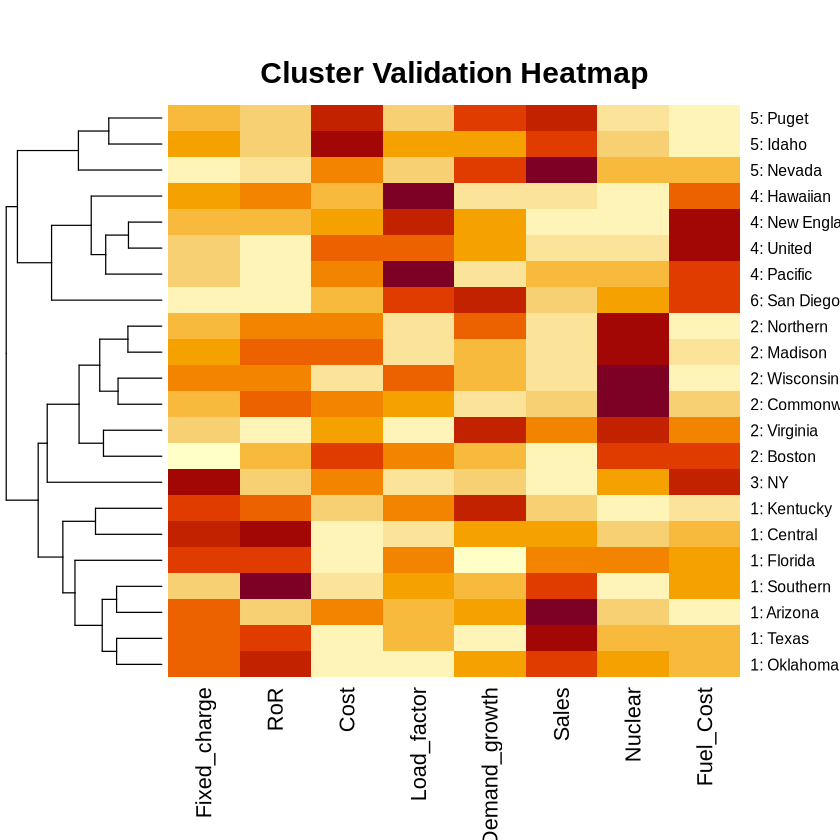

In [15]:
# Set labels as cluster membership and utility name
row.names(utilities.df.norm) <- paste(memb, ": ", row.names(utilities.df), sep = "")

# Plot heatmap
heatmap(utilities.df.norm, Colv=NA, hclustfun=hclust,
        main="Cluster Validation Heatmap")

### 📋 Interpretation: Heatmap Analysis

**How to Read the Heatmap**:
- **Row labels**: `Cluster#: Company Name`
- **Colors**: Red = high values, yellow/white = low values (normalized)
- **Row dendrogram** (left): Shows hierarchical relationships
- **Colv=NA**: Columns NOT clustered (keep original variable order)

**Validation Checklist**:
- [ ] Do companies in same cluster show similar color patterns?
- [ ] Are there distinct blocks/bands corresponding to clusters?
- [ ] Can you describe what makes each cluster unique?

**Example Insights**:
- Cluster 1 might be "High Sales, High Fixed Costs" (all red in those columns)
- Cluster 3 might be "Low RoR, High Fuel Costs"

---

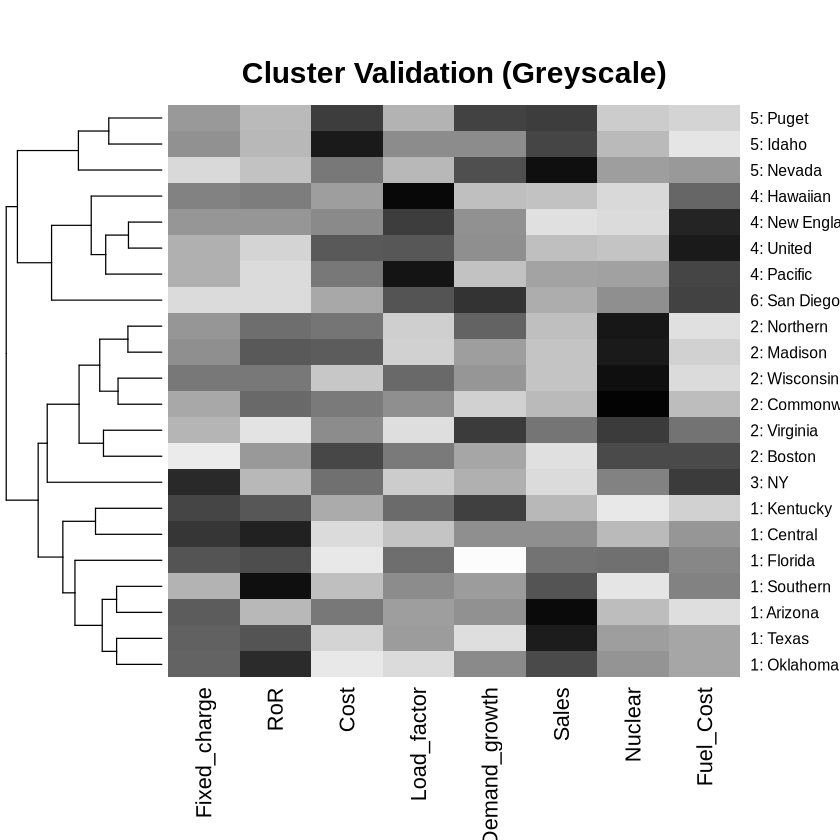

In [16]:
# Grey scale version (better for publications)
# rev() reverses the color mapping to large = dark
heatmap(as.matrix(utilities.df.norm), Colv = NA, hclustfun = hclust,
        col=rev(paste("gray",1:99,sep="")),
        main="Cluster Validation (Greyscale)")

### 📋 Interpretation: Greyscale Heatmap

**Why Greyscale?**
- Better for **printing** or color-blind audiences
- Dark = high values, light = low values
- Often clearer for identifying patterns

**Business Reporting Tip**: Use greyscale in formal reports, colored in presentations.

---

## Part 4: Non-hierarchical Clustering - k-Means

### k-Means vs Hierarchical Clustering

| Feature | Hierarchical | k-Means |
|---------|--------------|----------|
| **Approach** | Bottom-up (agglomerative) | Partition-based |
| **Output** | Dendrogram (all levels) | Single partition |
| **Speed** | Slower (O(n³)) | Faster (O(nki)) |
| **Must specify k?** | No (choose later from tree) | Yes (upfront) |
| **Best for** | Small datasets, exploration | Large datasets, known k |
| **Randomness** | Deterministic | Random (set.seed!) |

### How k-Means Works

```
1. Randomly place k centroids
   ⭐ ⭐ ⭐

2. Assign each point to nearest centroid
   ⭐●●  ⭐●  ⭐●●●

3. Recalculate centroids (mean of assigned points)
    ⭐   ⭐    ⭐

4. Reassign points, recalculate...
   Repeat until no changes (convergence)
```

**Goal**: Minimize **within-cluster sum of squares** (WCSS)

---

In [17]:
set.seed(123) # Set random seed for reproducibility

# Load and preprocess data (if not already done)
utilities.df <- mlba::Utilities %>%
  column_to_rownames("Company")

# Normalized distance:
utilities.df.norm <- scale(utilities.df)

# Run kmeans algorithm for k=6
km <- kmeans(utilities.df.norm, 6)

# Show cluster membership
cat("Cluster assignments:\n")
print(sort(km$cluster))

Cluster assignments:
     Boston     Hawaiian   New England     Pacific     San Diego       United 
           1            1            1            1            1            1 
    Central      Florida      Oklahoma        Texas     Arizona      Kentucky 
           2            2            2            2            3            3 
    Southern     Virginia           NY Commonwealth     Madison      Northern 
           3            3            4            5            5            5 
   Wisconsin        Idaho       Nevada        Puget 
           5            6            6            6 


### 📋 Interpretation: k-Means Cluster Assignments

**Key Differences from Hierarchical**:
- Cluster numbers (1-6) are **arbitrary labels**
- No hierarchical relationship between clusters
- Running again with different seed may give different labels (but same groupings)

**⚠️ CRITICAL**: `set.seed()` ensures **reproducibility** for this random algorithm!

---

### Examining k-Means Results

In [18]:
# Centroids (cluster centers)
cat("Cluster centroids (means):\n")
print(round(km$centers, 2))

Cluster centroids (means):
  Fixed_charge   RoR  Cost Load_factor Demand_growth Sales Nuclear Fuel_Cost
1        -0.62 -0.63  0.20        1.15          0.06 -0.74   -0.37      1.18
2         0.74  1.08 -1.51       -0.62         -1.00  0.55   -0.38     -0.40
3         0.09  0.13 -0.18       -0.12          0.36  0.15   -0.32     -0.23
4         2.04 -0.86  0.58       -1.30         -0.72 -1.58    0.21      1.69
5         0.05  0.57  0.24       -0.30         -0.01 -0.59    1.74     -0.84
6        -0.60 -0.83  1.34       -0.48          0.99  1.86   -0.71     -0.97


### 📋 Interpretation: Cluster Centroids

**What Are Centroids?**
- **Mean value** of each variable for all observations in that cluster
- The "typical" member of each cluster
- Used to assign new observations to clusters

**How to Use This Table**:
1. **Compare across rows**: How does Cluster 1 differ from Cluster 2?
2. **Look for extremes**: High/low values define cluster characteristics
3. **Name your clusters**: "High Sales, Low Cost" vs "Small, High Margin"

**Business Value**: These profiles become your **segment definitions** for targeting!

---

In [19]:
# Within-cluster sum of squares
cat("Within-cluster sum of squares (by cluster):\n")
print(round(km$withinss, 2))

cat("\nTotal within-cluster SS:\n")
print(round(km$tot.withinss, 2))

# Cluster sizes
cat("\nCluster sizes:\n")
print(km$size)

Within-cluster sum of squares (by cluster):
[1] 21.19 12.20 10.77  0.00  5.83  9.53

Total within-cluster SS:
[1] 59.53

Cluster sizes:
[1] 6 4 4 1 4 3


### 📋 Interpretation: Within-Cluster Sum of Squares (WCSS)

**What is WCSS?**

For each cluster: $WCSS = \sum_{i \in cluster} ||x_i - centroid||^2$

**Interpretation**:
- **Lower WCSS** = More compact, homogeneous cluster
- **Higher WCSS** = More spread out, heterogeneous cluster

**Why This Matters**:
- High WCSS for a cluster → May need to **split** it further
- Very low WCSS across all clusters → May have **too many** clusters

**Cluster Sizes**:
- Ideally reasonably balanced (no cluster too small/large)
- Tiny clusters (<3%) might be outliers
- Huge clusters (>40%) might need splitting

---

### Visualizing Cluster Profiles with Parallel Coordinates

agg_record_2122885085 
                    2

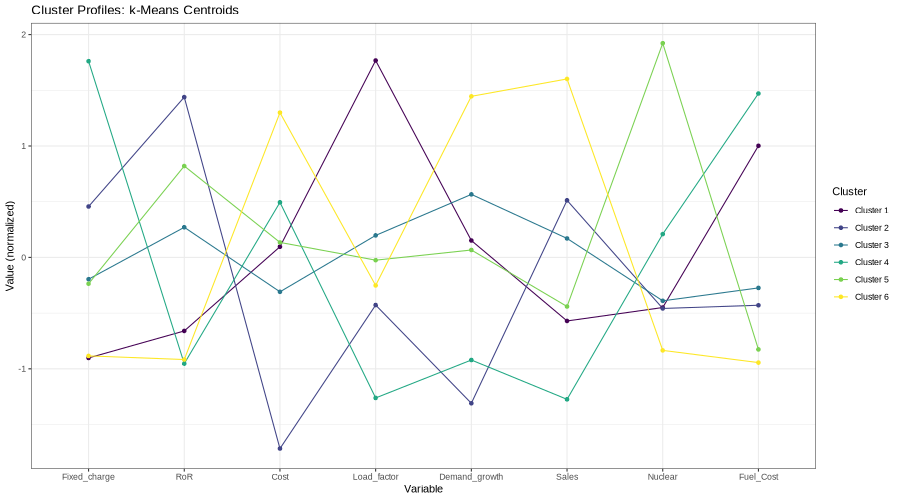

In [21]:
library(GGally)

# Create data frame with centroids
centroids <- data.frame(km$centers)
centroids['Cluster'] = paste('Cluster', seq(1, 6))

# Save and display as PNG to avoid text bunching
png("cluster_profiles.png", width=900, height=500)
print(ggparcoord(centroids, columns=1:8, groupColumn='Cluster', showPoints=TRUE) +
    scale_color_viridis_d() +
    labs(x='Variable', y='Value (normalized)',
         title='Cluster Profiles: k-Means Centroids') +
    theme_bw())
dev.off()
display_png(file="cluster_profiles.png")

### 📋 Interpretation: Parallel Coordinates Plot

**How to Read This Chart**:
- **Each colored line** = One cluster's profile
- **X-axis**: Variables (all 8 characteristics)
- **Y-axis**: Normalized values (z-scores)
- **High point**: Cluster is above average on that variable
- **Low point**: Cluster is below average

**What to Look For**:
1. **Distinct patterns**: Lines should NOT overlap too much
2. **Cluster characterization**: 
   - Which cluster is consistently high/low?
   - Which variables separate clusters most?
3. **Naming opportunities**: "High-cost, low-demand" vs "Efficient operators"

**Business Use Case**: This becomes your **customer persona** or **market segment** visualization!

---

## Part 5: Choosing the Optimal Number of Clusters (k)

### The k-Selection Problem

**Challenge**: k-means requires you to specify k **before** running the algorithm!

**Trade-offs**:
```
k=1: Everything same cluster → Useless
k=n: Each observation own cluster → Also useless

Need: Sweet spot between simplicity and detail
```

### Common Approaches

| Method | Description | Pros/Cons |
|--------|-------------|------------|
| **Elbow Method** | Plot WCSS vs k, look for "elbow" | Easy, visual, but subjective |
| **Silhouette** | Measure how well separated clusters are | More objective, computationally intensive |
| **Gap Statistic** | Compare to random data | Statistical rigor, complex |
| **Business Rules** | Domain knowledge (e.g., 5 price tiers) | Practical, actionable |

**Best Practice**: Combine **elbow method** with **business judgment**!

---

### The Elbow Method

In [22]:
# Run k-means for k=1 to 6, compute average WCSS
result <- tibble()
for (k in 1:6) {
  km <- kmeans(utilities.df.norm, k)
  result <- bind_rows(result, tibble(k=k, average_withinss=mean(km$withinss)))
}

# Display results
print(result)

# A tibble: 6 × 2
      k average_withinss
  <int>            <dbl>
1     1           168.  
2     2            69.4 
3     3            35.6 
4     4            20.1 
5     5            13.5 
6     6             9.61


### 📋 Interpretation: WCSS by Number of Clusters

**Expected Pattern**:
- WCSS **always decreases** as k increases
- More clusters → Each cluster tighter → Lower WCSS
- At k=n, WCSS = 0 (each point is a cluster)

**Key Question**: When does adding clusters give **diminishing returns**?

---

agg_record_1178521741 
                    2

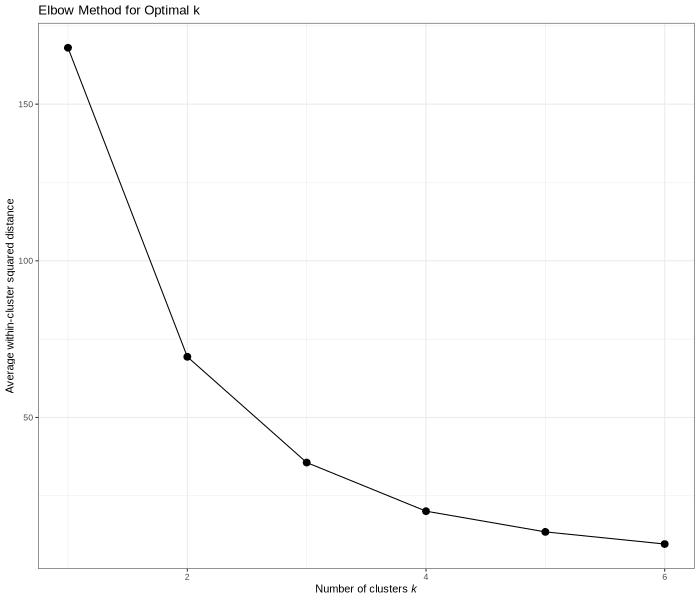

In [23]:
# Save and display as PNG to avoid text bunching
png("elbow_plot.png", width=700, height=600)
print(ggplot(result, aes(x=k, y=average_withinss)) +
  geom_line() +
  geom_point(size=3) +
  labs(y="Average within-cluster squared distance",
       x=expression(paste("Number of clusters ", italic("k"))),
       title="Elbow Method for Optimal k") +
  theme_bw())
dev.off()
display_png(file="elbow_plot.png")

### 📋 Interpretation: The Elbow Plot

**How to Find the "Elbow"**:

```
WCSS
  │
  │●     Steep drop (big improvement)
  │ \
  │  ●   
  │   \  ← ELBOW (optimal k)
  │    ●─●─● Flat (little improvement)
  └─────────────── k
```

**What to Look For**:
1. **Sharp drop** for small k (2-3): Each cluster adds value
2. **Elbow/bend**: Point where slope flattens
3. **Flat tail**: Adding more clusters doesn't help much

**Common Issue**: Elbow may be **unclear** (gradual curve)

**Solution**: Use **business constraints**!
- Marketing budget for 4 campaigns → k=4
- Product tiers (Basic/Standard/Premium) → k=3
- Industry benchmarks (utilities often grouped 3-5)

---

### Evaluating Distance Between Cluster Centroids

In [24]:
# Re-run k-means with chosen k (e.g., k=6)
set.seed(123)
km <- kmeans(utilities.df.norm, 6)

# Compute distances between cluster centroids
centroid_distances <- dist(km$centers)
cat("Distances between cluster centroids:\n")
print(round(as.matrix(centroid_distances), 2))

Distances between cluster centroids:
     1    2    3    4    5    6
1 0.00 4.01 2.38 3.89 3.54 4.04
2 4.01 0.00 2.32 4.43 3.29 4.43
3 2.38 2.32 0.00 3.85 2.38 2.81
4 3.89 4.43 3.85 0.00 4.17 5.56
5 3.54 3.29 2.38 4.17 0.00 4.08
6 4.04 4.43 2.81 5.56 4.08 0.00


### 📋 Interpretation: Inter-Centroid Distances

**What This Shows**:
- Distance between **cluster centers**
- **Larger distances** = More distinct clusters
- **Small distances** = Clusters may be too similar

**Quality Check**:
- ✅ All distances reasonably large (>2 on normalized scale)
- ⚠️ Some pairs very close (<1) → Consider merging
- ❌ Most pairs close → Too many clusters (reduce k)

**Business Validation**:
- Can you explain the **difference** between close clusters?
- Would you treat those segments differently in practice?
- If not → Merge them!

---

## Summary: Cluster Analysis Best Practices

### 🎯 Key Takeaways

#### 1. **ALWAYS Normalize Your Data**
```r
data.norm <- scale(data)  # Before ANY clustering!
```
- Prevents large-scale variables from dominating
- Makes all variables contribute equally

#### 2. **Choose the Right Method**

| Use Hierarchical When... | Use k-Means When... |
|-------------------------|---------------------|
| Dataset small (<500 obs) | Dataset large (>1000 obs) |
| Exploring/don't know k | You know k (business requirement) |
| Want full dendrogram | Need speed/efficiency |
| Prefer deterministic results | Random initialization OK (use set.seed!) |

#### 3. **Linkage Method Matters** (Hierarchical)
- **Average**: Most balanced, recommended default
- **Ward**: Equal-sized clusters
- **Single**: Avoid (creates chains)
- **Complete**: Compact clusters

#### 4. **Choosing k**
- Use **elbow method** as starting point
- Apply **business judgment** (budget, operations, interpretability)
- Check **inter-centroid distances** (clusters should be distinct)
- Validate with **heatmaps** and **profile plots**

#### 5. **Validate Your Clusters**
- [ ] Heatmap shows distinct patterns?
- [ ] Cluster sizes reasonable (not too unbalanced)?
- [ ] Can you name/describe each cluster?
- [ ] Would you treat segments differently in practice?
- [ ] Do clusters make business sense?

---

### 📚 Function Reference

| Function | Package | Purpose |
|----------|---------|----------|
| `scale()` | base | Normalize variables (mean=0, sd=1) |
| `dist()` | stats | Compute distance matrix |
| `hclust()` | stats | Hierarchical clustering |
| `cutree()` | stats | Extract cluster assignments from dendrogram |
| `kmeans()` | stats | k-means clustering |
| `ggdendrogram()` | ggdendro | Visualize dendrogram with ggplot |
| `heatmap()` | stats | Cluster validation heatmap |
| `ggparcoord()` | GGally | Parallel coordinates plot for profiles |

---

### ⚠️ Common Pitfalls

| Mistake | Consequence | Fix |
|---------|-------------|-----|
| **Forgetting to normalize** | Wrong clusters (scale-dominated) | `scale()` first! |
| **Using single linkage** | Unbalanced, chain-like clusters | Use average/ward |
| **Ignoring business context** | Unactionable segments | Involve stakeholders early |
| **Too many clusters** | Overfitting, too complex | Use elbow + business rules |
| **Not setting seed (k-means)** | Irreproducible results | `set.seed(123)` |
| **Treating cluster # as meaningful** | Wrong interpretation | Cluster labels are arbitrary! |

---

### 💼 Business Applications Checklist

After clustering, ask:

**Interpretation**:
- [ ] What characterizes each cluster? (Name them!)
- [ ] What business metrics differ across clusters?
- [ ] Which clusters are most/least valuable?

**Actionability**:
- [ ] Can you identify new customers' clusters?
- [ ] Do you have strategies for each segment?
- [ ] Can operations/marketing execute on these segments?

**Validation**:
- [ ] Do domain experts agree with segments?
- [ ] Do segments align with known market structure?
- [ ] Are clusters stable over time?

---

### 🔗 Connections to Other Modules

- **Module 2.2 (PCA)**: Use PCA to reduce dimensions **before** clustering
- **Module 2.1 (LDA)**: LDA = supervised, Clustering = unsupervised
- **Module 4.1 (k-NN)**: Both use distance metrics and normalization
- **Module 5 (original)**: Discriminant analysis can follow clustering (if you label clusters)

**Workflow Combo**: 
1. PCA to reduce 50 variables → 10 components
2. k-means on components → Create segments
3. LDA/k-NN to classify new customers into segments

---

### 📖 Further Reading

- **DBSCAN**: Density-based clustering (handles noise, irregular shapes)
- **Gaussian Mixture Models**: Probabilistic clustering
- **Silhouette analysis**: More sophisticated k selection
- **Cluster stability**: Bootstrap methods for validation

---

## 🎓 You've Completed Module 5.1!

You now know how to:
- ✅ Compute and interpret distance metrics
- ✅ Build hierarchical clusters with dendrograms
- ✅ Implement k-means clustering
- ✅ Choose optimal number of clusters
- ✅ Validate and profile your segments
- ✅ Apply clustering to real business problems

**Next Step**: Apply these techniques to your own datasets! Start with 2-3 clusters and build intuition before going complex.

---